# **GIS × Python Tutorial 5.2 ~ geopandas での地理空間検索メソッド ~**

<br>

## **はじめに**
この記事は「GIS × Python Tutorial」の関連記事です。
今回は`geopandas.GeoDataFrame`での地理空間的なメソッドの使い方を解説します。このメソッドは shapely の geometry オブジェクトが使用されているので、ドキュメントは shapely の方を見た方が良いかもしれません。前回の記事を見ていない方は前回の記事もどうぞ。
<br>

## **空間検索とは**
例えば市町村の区域データとコンビニの位置情報データを 1つの地図に可視化した場合、人間の目で見ればどのコンビニが市町村の区域内に含まれるか、あるいは含まれないかが分かると思います。これは可視化された区域の空間とコンビニの座標を比べているからです。GIS では Geometry のオブジェクトをよく利用すると思いますが、この Geometry を利用し、座標の関係に基づいて地物を比較・検索する機能を空間検索と呼びます。


<br>


## **コード実行の準備**

### **Import**

In [1]:
# 今回使用するライブラリのインポート
from typing import List

import fiona
import geopandas as gpd
import japanize_matplotlib
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import shapely
from shapely.plotting import plot_points
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()
plt.style.use('ggplot')

### **データの作成**
適当にデータを作成します。

In [2]:
# 弘前城の位置
x1 = -31285.753
y1 = 67560.861
point1 = shapely.Point(x1, y1)

# 弘前城二の丸の位置
x2 = -31136.337
y2 = 67548.763

# ランダムな点群を作成
length = 200
distance = 100
xs = np.random.normal(
    loc=np.mean([x1, x2]), 
    scale=distance, 
    size=length
)
ys = np.random.normal(
    loc=y1, 
    scale=distance, 
    size=length
)
points = [shapely.Point(_x, _y) for _x, _y in zip(xs, ys)]

# GeoDataFrameの作成
IN_EPSG = 'EPSG:6678'
point_gdf = (
    gpd.GeoDataFrame(
        geometry=points,
        crs=IN_EPSG
    )
)

print(point_gdf.head(5).to_markdown())

|    | geometry                                      |
|---:|:----------------------------------------------|
|  0 | POINT (-31104.721849171943 67391.53674190957) |
|  1 | POINT (-31278.61748849311 67771.15239424302)  |
|  2 | POINT (-31103.364632008015 67492.15786856243) |
|  3 | POINT (-31132.949538147037 67563.94886745866) |
|  4 | POINT (-31250.861916179885 67524.06667904767) |


<br>

## **Geometry が指定された距離内にあるか判断**

これは geopandas にはメソッドが無いので バッファー を作成して計算する事になります。バッファー内にあるかどうかは `intersects`メソッドを使用して判断します。

`.intersects(A, B)`は A と B が空間の一部を共有している場合は True を返します。

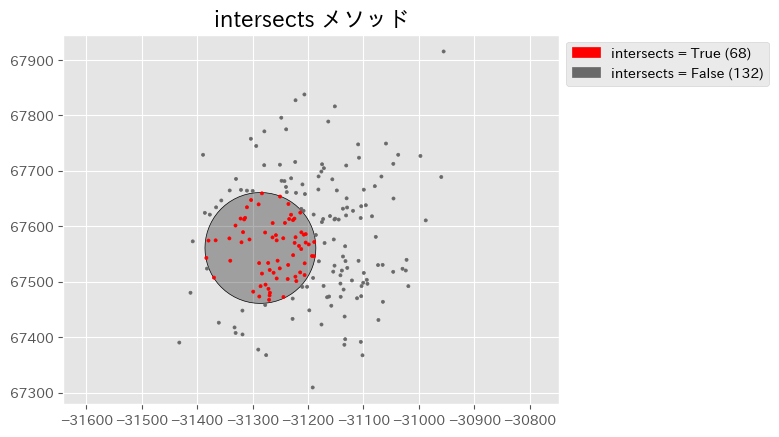

In [3]:
# 弘前城から100mのバッファーを作成する。
circle1 = point1.buffer(100)

true_color = '#ff0000'
false_color = '#696969'

func = lambda bool_: true_color if bool_ else false_color
point_gdf['intersects'] = point_gdf.intersects(circle1).apply(func)


# 可視化して確かめる
true_count = point_gdf[point_gdf['intersects'] == true_color].shape[0]
false_count = point_gdf.shape[0] - true_count
fig, ax= plt.subplots()
ax.set_title('intersects メソッド', fontsize=16)
plot_polygon(circle1, ax, False, color='black')
point_gdf.plot(ax=ax, color=point_gdf['intersects'], markersize=5)
patches = [
    matplotlib.patches.Patch(
        color=true_color, 
        label=f"intersects = True ({true_count})"
    ),
    matplotlib.patches.Patch(
        color=false_color, 
        label=f"intersects = False ({false_count})"
    ),
]
ax.legend(handles=patches, bbox_to_anchor=(1, 1))
ax.axis('equal');

バッファーを作成しなくとも`shapely.dwithin`を使用すれば距離を指定して空間検索を行う事も出来ます。

`shapely.dwithin(A, B, distance)`は A と B が指定された距離内にある場合にTrueを返します。

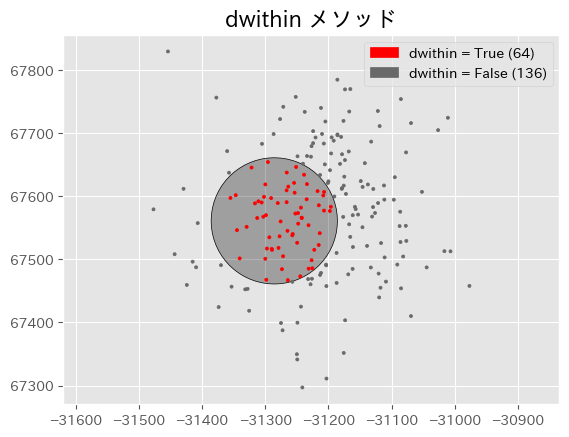

In [237]:
# 空間検索
point_gdf['dwithin'] =  [
    shapely.dwithin(point1, _pt, distance) 
    for _pt in point_gdf.geometry
]
point_gdf['dwithin'] = point_gdf['dwithin'].apply(func)


# 可視化して確かめる
true_count = point_gdf[point_gdf['dwithin'] == true_color].shape[0]
false_count = point_gdf.shape[0] - true_count
fig, ax= plt.subplots()
ax.set_title('dwithin メソッド', fontsize=16)
plot_polygon(circle1, ax, False, color='black')
point_gdf.plot(ax=ax, color=point_gdf['dwithin'], markersize=5)
patches = [
    matplotlib.patches.Patch(
        color=true_color, 
        label=f"dwithin = True ({true_count})"
    ),
    matplotlib.patches.Patch(
        color=false_color, 
        label=f"dwithin = False ({false_count})"
    ),
]
ax.legend(handles=patches, bbox_to_anchor=(1, 1))
ax.axis('equal');

<br>

## **データの準備**
次は様々ある空間検索のメソッドを試して挙動を見ていきますが、その前に Polygon のデータを作成しておきます。


In [247]:
polys = [
    shapely.Polygon(
        shell=[
            (0.0, 0.0),
            (10.0, 0.0),
            (10.0, 10.0),
            (0.0, 10.0)
        ],
        holes=[
            [
                (1, 6),
                (1, 9),
                (5, 9),
                (5, 6)
            ]
        ]
    ),
    shapely.Polygon(
        shell=[
            (10, 0),
            (13, 3),
            (13, 0)
        ]
    ),
    shapely.Polygon(
        shell=[
            (6, 5),
            (6, 9),
            (12, 9),
            (12, 5),
        ]
    ),
    shapely.Polygon(
        shell=[
            (1.5, 2),
            (1.5, 4),
            (4.5, 5),
            (4.5, 3)
        ]
    ),
    shapely.Polygon(
        shell=[
            (0, 0),
            (-5, 7),
            (0, 8)
        ]
    ),
    shapely.Polygon(
        shell=[
            (2, 0),
            (5, 0),
            (3, -3)
        ]
    ),
    shapely.Polygon(
        shell=[
            (2, 7),
            (2, 8),
            (4, 8),
            (4, 7)
        ]
    ),
    shapely.Polygon(
        shell=[
            (-5, 2),
            (-2.5, 0),
            (-5, 0)
        ]
    )
]

categories = [
    'メインの区画',
    '1点だけメインに触れている区画',
    '半分以上がメインに含まれている区画',
    '全てがメインに含まれている区画',
    'メインと点と辺を共有している区画',
    'メインと辺のみを共有している区画',
    'メインのホールに含まれる区画',
    '完全に離れている区画'
]

colors = [
    list(c) + [0.95] 
    for c in plt.colormaps.get_cmap('tab10').colors
]

gdf = gpd.GeoDataFrame({'category': categories}, geometry=polys)
print(gdf.to_markdown())

|    | category                           | geometry                                                           |
|---:|:-----------------------------------|:-------------------------------------------------------------------|
|  0 | メインの区画                       | POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0), (1 6, 1 9, 5 9, 5 6, 1 6)) |
|  1 | 1点だけメインに触れている区画      | POLYGON ((10 0, 13 3, 13 0, 10 0))                                 |
|  2 | 半分以上がメインに含まれている区画 | POLYGON ((6 5, 6 9, 12 9, 12 5, 6 5))                              |
|  3 | 全てがメインに含まれている区画     | POLYGON ((1.5 2, 1.5 4, 4.5 5, 4.5 3, 1.5 2))                      |
|  4 | メインと点と辺を共有している区画   | POLYGON ((0 0, -5 7, 0 8, 0 0))                                    |
|  5 | メインと辺のみを共有している区画   | POLYGON ((2 0, 5 0, 3 -3, 2 0))                                    |
|  6 | メインのホールに含まれる区画       | POLYGON ((2 7, 2 8, 4 8, 4 7, 2 7))                                |
|  7 | 完全に離れている区画               | POLYGON ((-5 2, -2.5 0, -5 0, -5 2))           

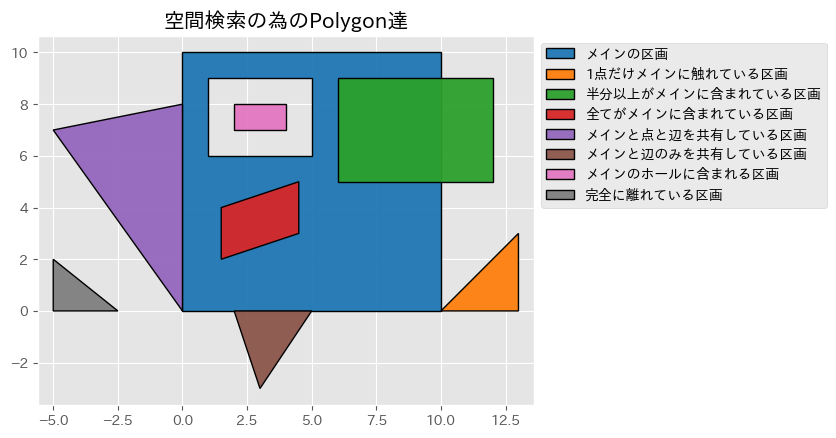

In [248]:
def plotting(poly, categories, colors, title, bools=None):
    fig, ax = plt.subplots()
    zipper = zip(polys, categories, colors)
    for i, (poly, category, color) in enumerate(zipper):
        if bools is None:
            plot_polygon(
                poly, ax, False, fc=color, 
                ec='black', lw=1, label=category
            )
        else:
            ec = 'red' if bools[i] else 'black'
            lw = 2 if bools[i] else 1
            plot_polygon(
                poly, ax, False, fc=color, 
                ec=ec, lw=lw, label=category
            )

    ax.set_title(title, fontsize=15)
    if bools is not None:
        patches = [
            matplotlib.patches.Patch(
                color='red', label="True"),
            matplotlib.patches.Patch(
                color='black', label="False"),
        ]
        ax.legend(
            handles=list(ax.patches)
              + patches, bbox_to_anchor=(1, 1))
    else:
        ax.legend(bbox_to_anchor=(1, 1))
    ax.axis('equal')


plotting(polys, categories, colors, '空間検索の為のPolygon達')

<br>

## **空間の一部を共有しているか**

先に説明した様に `gdf.intersects(target)` メソッドでは、**geometry と target が空間の一部を共有しているか**を判断し、共有している場合には True を返します。

|    | category                           | intersects   |
|---:|:-----------------------------------|:-------------|
|  0 | メインの区画                       | True         |
|  1 | 1点だけメインに触れている区画      | True         |
|  2 | 半分以上がメインに含まれている区画 | True         |
|  3 | 全てがメインに含まれている区画     | True         |
|  4 | メインと点と辺を共有している区画   | True         |
|  5 | メインと辺のみを共有している区画   | True         |
|  6 | メインのホールに含まれる区画       | False        |
|  7 | 完全に離れている区画               | False        |


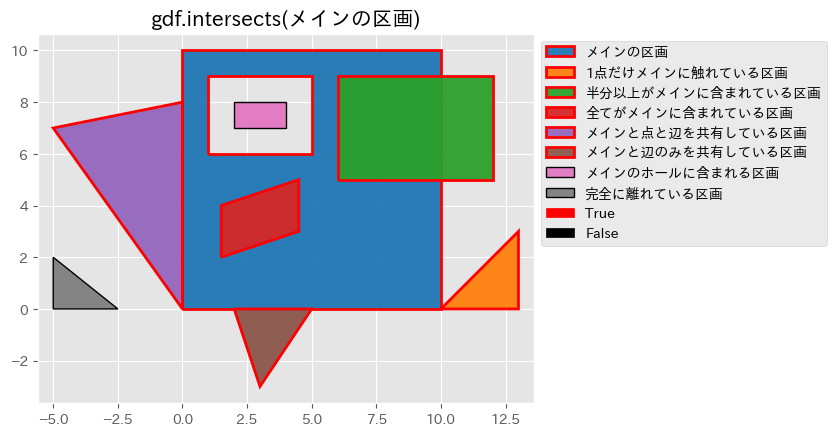

In [249]:
main_poly = gdf.geometry.iloc[0]

gdf['intersects'] = gdf.intersects(main_poly)
print(gdf.iloc[:, [0, 2]].to_markdown())

plotting(
    polys, categories, colors, 
    'gdf.intersects(メインの区画)', 
    gdf['intersects']
)

<br>

## **点または辺を共有しているか**

`gdf.touches(target)` メソッドでは、**geometry と target が点または辺を共有しているか**を判断し、共有している場合には True を返します。

|    | category                           | intersects   | touches   |
|---:|:-----------------------------------|:-------------|:----------|
|  0 | メインの区画                       | True         | False     |
|  1 | 1点だけメインに触れている区画      | True         | True      |
|  2 | 半分以上がメインに含まれている区画 | True         | False     |
|  3 | 全てがメインに含まれている区画     | True         | False     |
|  4 | メインと点と辺を共有している区画   | True         | True      |
|  5 | メインと辺のみを共有している区画   | True         | True      |
|  6 | メインのホールに含まれる区画       | False        | False     |
|  7 | 完全に離れている区画               | False        | False     |


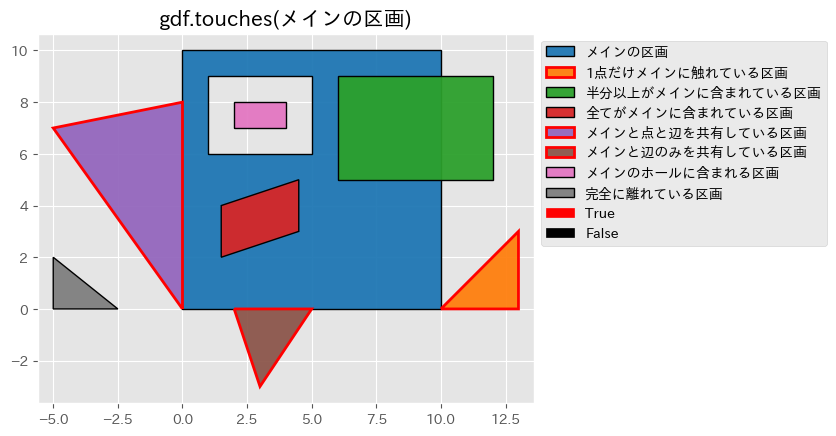

In [250]:
gdf['touches'] = gdf.touches(main_poly)
print(gdf.iloc[:, [0, 2, 3]].to_markdown())

plotting(
    polys, categories, colors, 
    'gdf.touches(メインの区画)', 
    gdf['touches']
)

<br>

## **gdf.geometry が target に完全に含まれるか**

`gdf.within(target)` メソッドでは、**gdf.geometry が 引数として与えた Polygon の中に完全に含まれるか**を判断し、共有している場合には True を返します。

|    | category                           | intersects   | touches   | within   |
|---:|:-----------------------------------|:-------------|:----------|:---------|
|  0 | メインの区画                       | True         | False     | True     |
|  1 | 1点だけメインに触れている区画      | True         | True      | False    |
|  2 | 半分以上がメインに含まれている区画 | True         | False     | False    |
|  3 | 全てがメインに含まれている区画     | True         | False     | True     |
|  4 | メインと点と辺を共有している区画   | True         | True      | False    |
|  5 | メインと辺のみを共有している区画   | True         | True      | False    |
|  6 | メインのホールに含まれる区画       | False        | False     | False    |
|  7 | 完全に離れている区画               | False        | False     | False    |


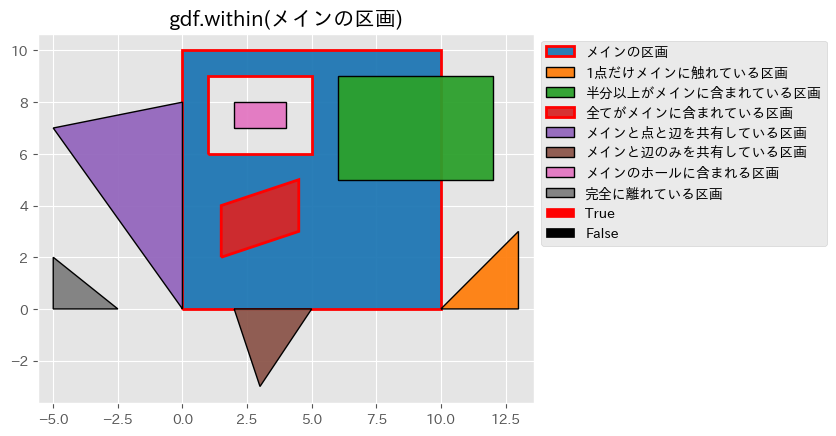

In [251]:
gdf['within'] = gdf.within(main_poly)
print(gdf.iloc[:, [0, 2, 3, 4]].to_markdown())

plotting(
    polys, categories, colors, 
    'gdf.within(メインの区画)', 
    gdf['within']
)

<br>

## **gdf.geometry と target が重なり合っているか**

`gdf.overlaps(target)` メソッドでは、**gdf.geometry が 引数として与えた Polygon と重なり合っているか**を判断し、重なっている場合には True を返します。この場合の「重なっている」とは点や線が同じ位置にあるという意味ではなく、「線が横切っている」という意味になるみたいですね。

|    | category                           | intersects   | touches   | within   | overlaps   |
|---:|:-----------------------------------|:-------------|:----------|:---------|:-----------|
|  0 | メインの区画                       | True         | False     | True     | False      |
|  1 | 1点だけメインに触れている区画      | True         | True      | False    | False      |
|  2 | 半分以上がメインに含まれている区画 | True         | False     | False    | True       |
|  3 | 全てがメインに含まれている区画     | True         | False     | True     | False      |
|  4 | メインと点と辺を共有している区画   | True         | True      | False    | False      |
|  5 | メインと辺のみを共有している区画   | True         | True      | False    | False      |
|  6 | メインのホールに含まれる区画       | False        | False     | False    | False      |
|  7 | 完全に離れている区画               | False        | False     | False    | False      |


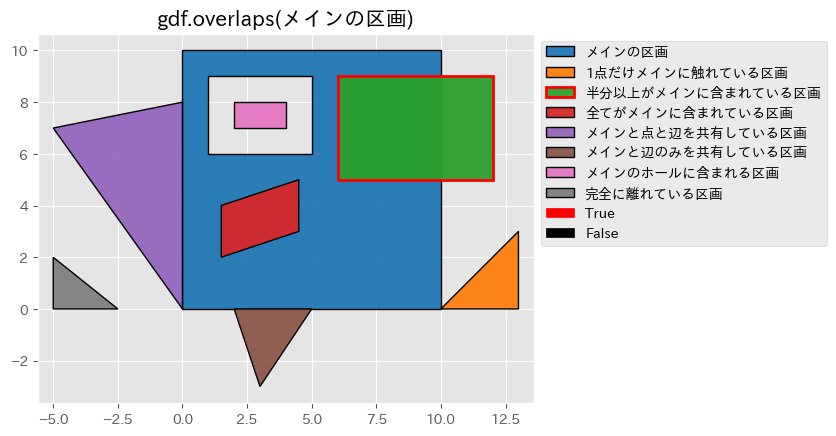

In [253]:
gdf['overlaps'] = gdf.overlaps(main_poly)
print(gdf.iloc[:, [0, 2, 3, 4, 5]].to_markdown())

plotting(
    polys, categories, colors, 
    'gdf.overlaps(メインの区画)', 
    gdf['overlaps']
)

<br>

## **target が gdf.geometry に完全に含まれるか**

within とは逆に **引数として与えた Polygon が gdf.geometryの中に完全に含まれているか**を判断する場合は `gdf.contains(target)`を使用します。

 - **shapely.within(A, B) == shapely.contains(B, A)**

今回は Polygon を用意していないのでここは飛ばします。



<br>

## **gdf.geometry が target に n%含まれているか**

こちらはメソッドが用意されていませんので、関数を作成して適用させてみましょう。

`gdf.intersection`では空間を共有している部分を shapely.Polygon で返します。この返って来た Polygon の面積と、元の Polygon の面積を比べる事で、n% 含まれているかを判断する事が出来ます。

|    | category                           | intersects   | touches   | within   | overlaps   | contained_50per   |
|---:|:-----------------------------------|:-------------|:----------|:---------|:-----------|:------------------|
|  0 | メインの区画                       | True         | False     | True     | False      | True              |
|  1 | 1点だけメインに触れている区画      | True         | True      | False    | False      | False             |
|  2 | 半分以上がメインに含まれている区画 | True         | False     | False    | True       | True              |
|  3 | 全てがメインに含まれている区画     | True         | False     | True     | False      | True              |
|  4 | メインと点と辺を共有している区画   | True         | True      | False    | False      | False             |
|  5 | メインと辺のみを共有している区画   | True         | True      | False    | False      | False             |
|  6 | メインのホールに含まれる区画       | False        | False     | False    | False      | False             |
|  7 | 完全に離れている区画               | False        | False     | Fa

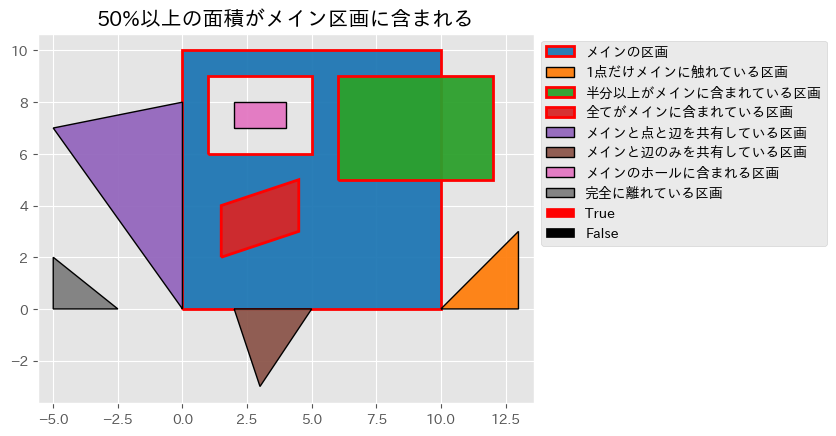

In [254]:
def n_per_contained(
    gdf: gpd.GeoDataFrame, 
    base_poly: shapely.Polygon,
    n_per: float = 0.5,
    return_bool: bool = False
) -> List[float]:
    """gdf.geometry が base_poly に n%含まれているか"""
    area = gdf.geometry.area
    contained_area = gdf.intersection(base_poly).area
    result = contained_area / area
    if return_bool:
        func = lambda v: True if n_per <= v else False
        return [func(_area) for _area in result]
    return result.tolist()



gdf['contained_50per'] = n_per_contained(gdf, main_poly, 0.5, True)
print(gdf.iloc[:, [0, 2, 3, 4, 5, 6]].to_markdown())

plotting(
    polys, categories, colors, 
    '50%以上の面積がメイン区画に含まれる', 
    gdf['contained_50per']
)

|    | category                           | intersects   | touches   | within   | overlaps   | contained_50per   | contained_90per   |
|---:|:-----------------------------------|:-------------|:----------|:---------|:-----------|:------------------|:------------------|
|  0 | メインの区画                       | True         | False     | True     | False      | True              | True              |
|  1 | 1点だけメインに触れている区画      | True         | True      | False    | False      | False             | False             |
|  2 | 半分以上がメインに含まれている区画 | True         | False     | False    | True       | True              | False             |
|  3 | 全てがメインに含まれている区画     | True         | False     | True     | False      | True              | True              |
|  4 | メインと点と辺を共有している区画   | True         | True      | False    | False      | False             | False             |
|  5 | メインと辺のみを共有している区画   | True         | True      | False    | False      | False             | False             |
|  6

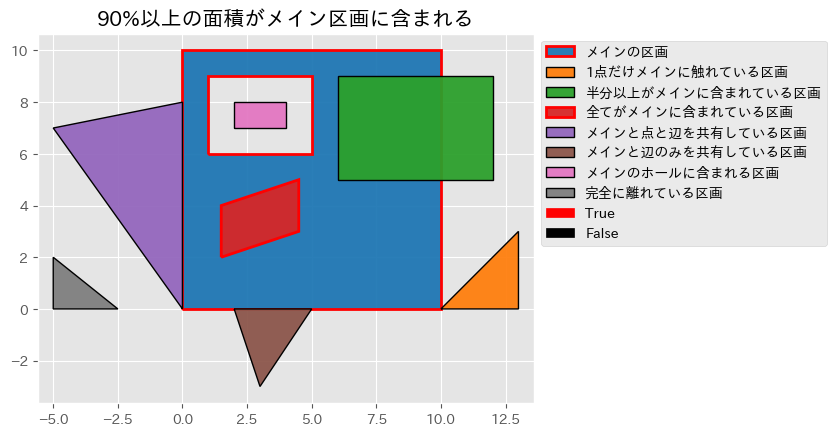

In [255]:
gdf['contained_90per'] = n_per_contained(gdf, main_poly, 0.9, True)
print(gdf.iloc[:, [0, 2, 3, 4, 5, 6, 7]].to_markdown())

plotting(
    polys, categories, colors, 
    '90%以上の面積がメイン区画に含まれる', 
    gdf['contained_90per']
)

<br>

## **空間検索を利用したデータ抽出**

ここまでで空間検索を使用した bool値の取得方法を解説してきましたが、実際に GeoDataFrame で使用する場合は Query を行う場合も多くあるかと思います。`gdf[gdf.intersects(target)].copy()`の様に Query を行う事も可能ですが、geopandas では `sindex（Spatial Index）`を使用して True と判断された Index を取得する事も可能です。

In [268]:
q_idx = gdf.sindex.query(main_poly, predicate='intersects', sort=True)
print(f"intersectsでTrueとなったIndex: {q_idx}")

intersectsでTrueとなったIndex: [0 1 2 3 4 5]


In [270]:
# indexで取得
_gdf = gdf.iloc[q_idx].copy()

有効な Query 方法は`gdf.sindex.valid_query_predicates`で見る事が出来ます。

In [273]:
gdf.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}